In [5]:
# imports
import os
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import pandas as pd
from bayesopt_server.utils import _dim_grid, get_lse_contour
from bayesopt_server.benchmark.test_functions import novel_detection_testfun, novel_discrimination_testfun 
%matplotlib inline

In [21]:
figdir = '../figs/'
datadir = '~/Downloads'
ci_level = 95 # set to 95 for final plots, but None is much faster
df = pd.read_csv(os.path.join(datadir, 'bigbench_newpriors_final_seed_3.csv'))

In [22]:
# parse which model we used
df['Model'] = "Nonmonotonic RBF (ours)"
df.loc[(df['MonotonicGP_monotonic_idxs'] == '[1]') | (df['MonotonicGPLSETS_monotonic_idxs'] == '[1]') ,'Model'] = "Monotonic RBF (ours)"
# GPClassificationModel (vs MonotonicGP with no monotonicity indices) is how we handle the Song model
df.loc[df['experiment_model'] == 'GPClassificationModel','Model'] = "Linear-Additive"

# parse acquisition functionÏ
df['acqf'] = df['experiment_acqf']
# The only TS acquisition we ran was MCLSETS
df.loc[df['experiment_model'] == 'MonotonicGPLSETS','acqf'] = "MCLSETS"
# If we only fit the model once, it was Sobol
df.loc[df['ModelWrapperStrategy_n_trials'] == 1,'acqf'] = "Sobol"

# now standardize the acqf names (since the monotonic and nonmonotonic acqf use slightly different
# codepaths due to rejection sampling, they have different names in the raw data)
acqf_name_remap = {"Sobol":"Sobol",
"MonotonicMCLSE":"LSE (ours)",
"MonotonicBernoulliMCMutualInformation":"BALD",
"MonotonicMCPosteriorVariance":"BALV",
"MCLSETS":"LSETS (ours)",
"MCPosteriorVariance":"BALV",
"MCLevelSetEstimation":"LSE (ours)",
"BernoulliMCMutualInformation":"BALD"}
df['Acquisition'] = df.acqf.map(acqf_name_remap)

df['test_function'] = "Audiometric"
df.loc[df['experiment_name'] == 'hairtie_hard','test_function'] = "Novel Discrimination"
df.loc[df['experiment_name'] == 'hairtie_easy','test_function'] = "Novel Detection"

df['rmse_p'] = np.sqrt(df['mean_square_err_p'])
df['rmse_thresh'] = np.sqrt(df['mean_square_err_thresh'])

audiometric_ids = df.experiment_name.str.split(r"song_p([^_]*)_b([0-9.]*)", expand=True).drop(columns=[0, 3])
audiometric_ids.columns = ('Phenotype', 'Beta')
df = pd.concat([df, audiometric_ids], axis=1)

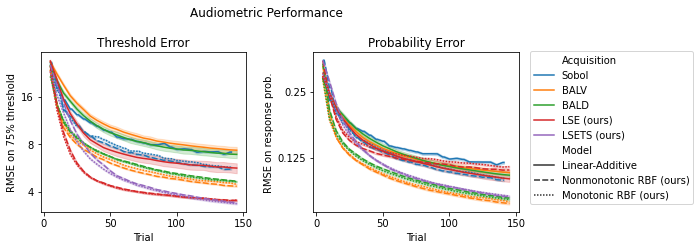

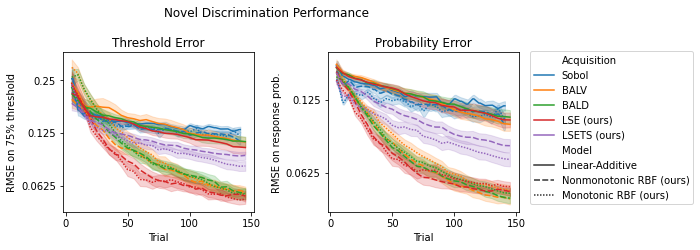

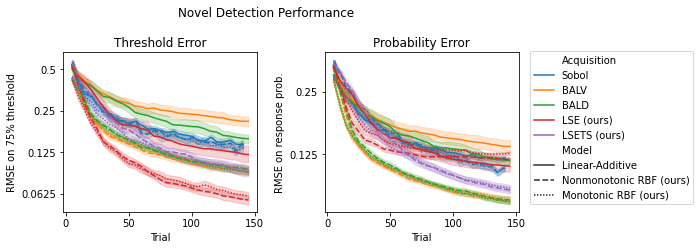

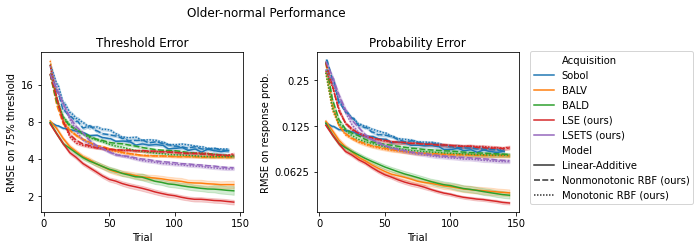

In [23]:
from matplotlib.ticker import FuncFormatter, ScalarFormatter, AutoMinorLocator

def make_perf_plot(df, title): 
    fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.5))
    fig.suptitle(title)
    g1 = sns.lineplot(data=df, x="trial_id", y='rmse_thresh', style="Model", ci=ci_level, style_order=['Linear-Additive','Nonmonotonic RBF (ours)', 'Monotonic RBF (ours)'], hue="Acquisition", hue_order=['Sobol','BALV','BALD','LSE (ours)','LSETS (ours)'], ax=ax[0])
    g1.set_xlabel("Trial")
    g1.set_ylabel("RMSE on 75% threshold")
    g1.set_title("Threshold Error")
    g1.set_yscale("log", base=2)
    g1.yaxis.set_major_formatter(FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log2(y),0)))).format(y)))

    g1.legend().set_visible(False)

    g2 = sns.lineplot(data=df, x="trial_id", y='rmse_p', style="Model", ci=ci_level, style_order=['Linear-Additive','Nonmonotonic RBF (ours)', 'Monotonic RBF (ours)'], hue="Acquisition", hue_order=['Sobol','BALV','BALD','LSE (ours)','LSETS (ours)'], ax=ax[1])
    g2.set_xlabel("Trial")
    g2.set_ylabel("RMSE on response prob.")
    g2.set_title("Probability Error")
    g2.legend().set_visible(False)
    g2.set_yscale("log", base=2)
    g2.yaxis.set_major_formatter(FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log2(y),0)))).format(y)))

    fig.tight_layout()
    handles, labels = ax[0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc="right", bbox_to_anchor=(1.3, 0.5))
    return fig, lgd

fig, lgd = make_perf_plot(df[df.test_function=="Audiometric"], "Audiometric Performance")
fig.savefig(figdir+"audiometric_perf.pdf",bbox_extra_artists=(lgd,),
        bbox_inches="tight")
fig, lgd = make_perf_plot(df[df.test_function=="Novel Discrimination"], "Novel Discrimination Performance")
fig.savefig(figdir+"disc_perf.pdf",bbox_extra_artists=(lgd,),
        bbox_inches="tight")
fig, lgd = make_perf_plot(df[df.test_function=="Novel Detection"], "Novel Detection Performance")
fig.savefig(figdir+"det_perf.pdf",bbox_extra_artists=(lgd,),
        bbox_inches="tight")
fig, lgd = make_perf_plot(df[df.Phenotype=="Older-normal"], "Older-normal Performance")
fig.savefig(figdir+"older-normal_pref.pdf",bbox_extra_artists=(lgd,),
        bbox_inches="tight")

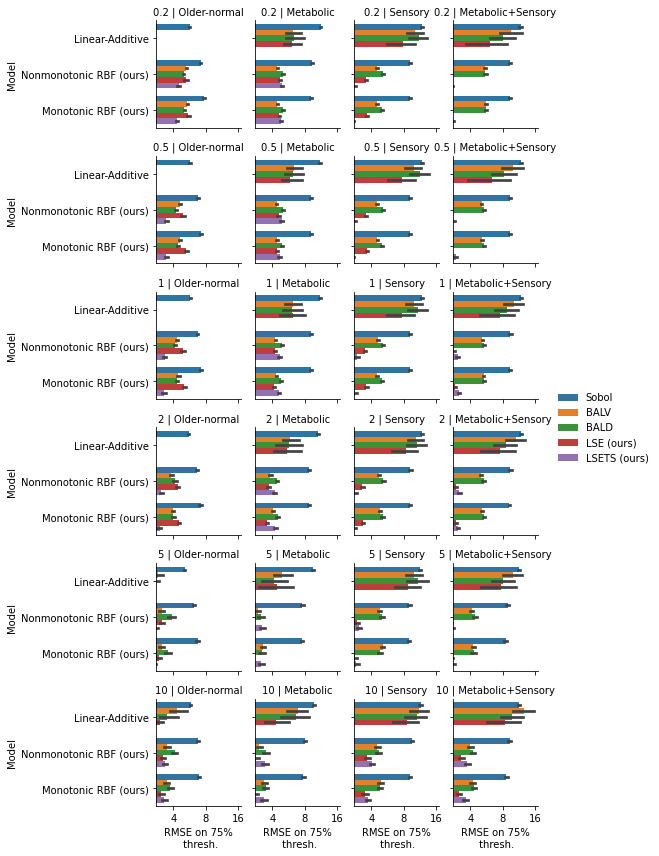

In [24]:
maxt = df[(df.final==True)].trial_id.max()

g = sns.FacetGrid(df[(df.final==True) & (df.test_function=="Audiometric")], col="Phenotype", row="Beta", row_order=["0.2", "0.5", "1", "2", "5", "10"], col_order=["Older-normal","Metabolic","Sensory","Metabolic+Sensory"], height=2, aspect=1)
g.map_dataframe(sns.barplot, 'rmse_thresh', "Model", hue="Acquisition", dodge=True, palette="tab10", hue_order=['Sobol','BALV','BALD','LSE (ours)','LSETS (ours)'], order = ['Linear-Additive','Nonmonotonic RBF (ours)', 'Monotonic RBF (ours)'], ci=ci_level)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_xlabels("RMSE on 75%\n thresh.")
g.tight_layout()
g.add_legend(loc="right", bbox_to_anchor=(1.02, 0.5))
for a in g.axes.ravel(): 
    a.set_xscale('log', base=2)
    a.xaxis.set_major_formatter(FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log2(y),0)))).format(y)))
plt.savefig(figdir+"audio_thresh_final.pdf")

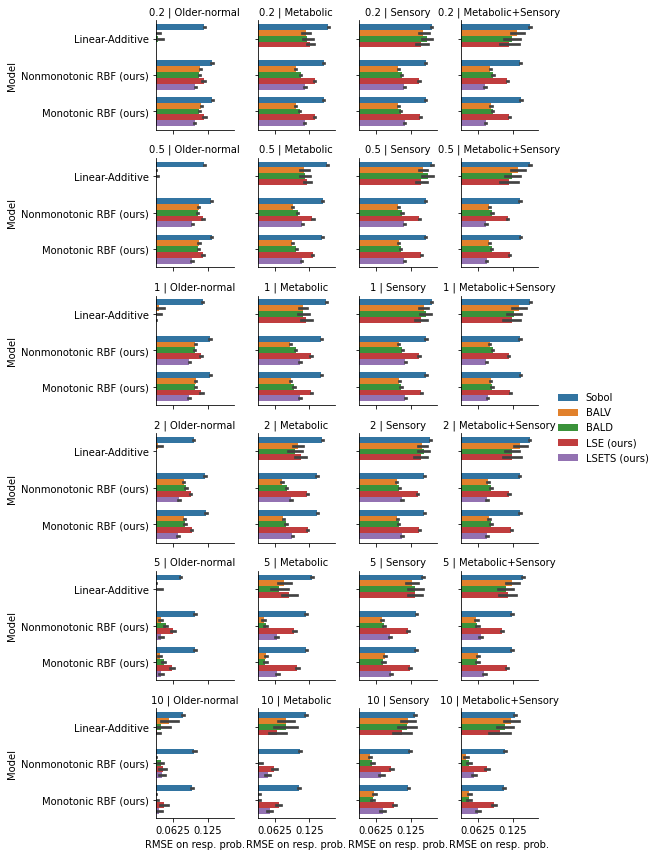

In [25]:
g = sns.FacetGrid(df[(df.final==True) & (df.test_function=="Audiometric")], col="Phenotype", row="Beta", row_order=["0.2", "0.5", "1", "2", "5", "10"], 
col_order=["Older-normal","Metabolic","Sensory","Metabolic+Sensory"], height=2, aspect=1)
g.map_dataframe(sns.barplot, 'rmse_p', "Model", hue="Acquisition", dodge=True, palette="tab10", hue_order=['Sobol','BALV','BALD','LSE (ours)','LSETS (ours)'], order = ['Linear-Additive','Nonmonotonic RBF (ours)', 'Monotonic RBF (ours)'], ci=ci_level)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_xlabels("RMSE on resp. prob.")
g.tight_layout()
g.add_legend(loc="right", bbox_to_anchor=(1.02, 0.5))
for a in g.axes.ravel(): 
    a.set_xscale('log', base=2)
    a.xaxis.set_major_formatter(FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log2(y),0)))).format(y)))
plt.savefig(figdir+"audio_p_final.pdf")